In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# all_data ใช้สำหรับตอนทำ test data เท่านั้น ไม่งั้นจะเกิด data leakage
all_data = pd.concat((df, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

y_train = df['SalePrice'].values

# นำ SalePrice ออก
df.drop('SalePrice', axis = 1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.000,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.000,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.000,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.000,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


# Understanding Data
ก่อนจะเริ่มกระบวนการ เราต้องเข้าใจความหมายและลักษณะของข้อมูลเสียก่อนจึงจะประมวลผลข้อมูลได้อย่างเหมาะสม<br>
คอลัมน์ใน dataset มีความหมายและแบ่งประเภทได้ดังนี้

* Numerical:  เป็นข้อมูลประเภทตัวเลข มีทั้งเป็นค่าต่อเนื่องและไม่ต่อเนื่อง
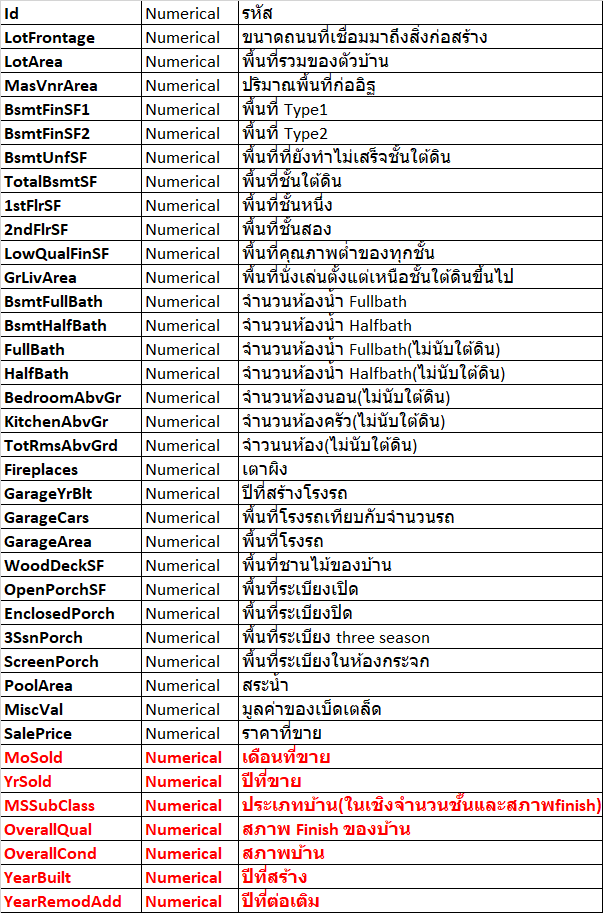


* Non-numerical:  ข้อมูลที่ชี้บ่งถึงกลุ่ม/ประเภทของข้อมูล ข้อมูลบางชนิดสามารถนำมาเรียงกันเป็นลำดับได้อย่างมีนัยยะ(Ordinal)
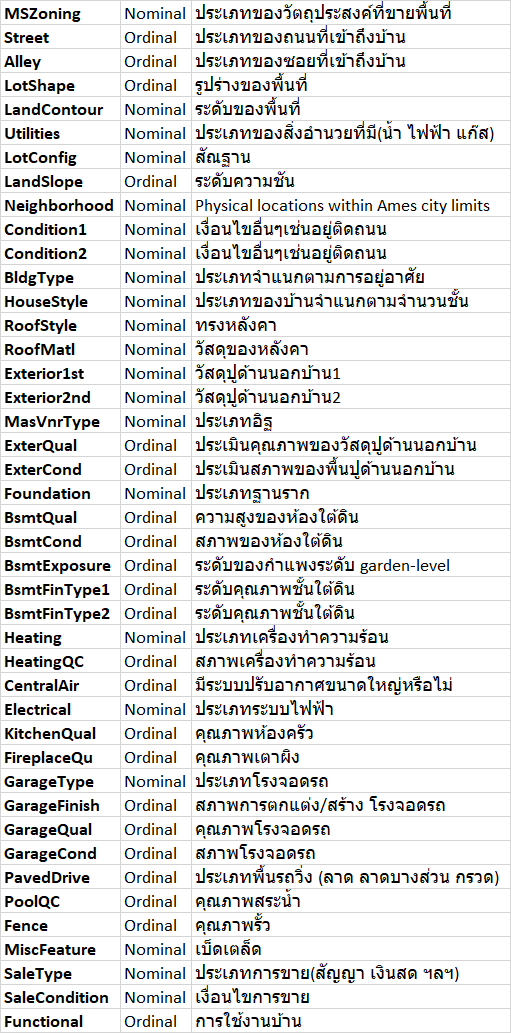

แถวสีแดงในตารางเป็นข้อมูลที่มีลักษณะเป็น categorical แต่กลับถูกบันทึกค่าเป็น numerical 

* OverallCond และ OverallQual -  สภาพและความสมบูรณ์ของบ้าน ถูกเก็บเป็นเลข 1-10 แต่จริงๆแล้วเป็น ordinal scale
* YrSold ,MoSold, YearBuilt,  และ YearRemodAdd - ปีและเดือน ล้วนเป็น ordinal
* MSSubClass เป็นข้อมูลที่ไม่สามารถจัดเรียงอย่างมีนัยยะได้ว่าค่าไหนมากน้อยกว่ากัน ฉะนั้นจึงเป็น nominal scale

In [3]:
# drop id ออก เพราะไม่มีประโยชน์
df = df.drop('Id', axis = 1)

แยกประเภทข้อมูลใส่ list ได้ดังนี้

In [4]:
numerical_feat = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'
,'1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr'
,'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF'
,'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

ordinal_feat = ['Street','Alley','LotShape','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
               ,'HeatingQC','CentralAir','KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','Functional'
               ,'OverallCond','OverallQual','YrSold','MoSold','YearBuilt', 'YearRemodAdd']

nominal_feat = ['MSZoning','LandContour','Utilities','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle'
               ,'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','GarageType','MiscFeature'
                ,'SaleType','SaleCondition','MSSubClass'
               ]

In [5]:
len(numerical_feat)

30

# Data Preprocess
* Impute missing value
* Modify Numerical data
* Modify Categorical data
* Feature Selection

# Consider Target Variable

<AxesSubplot:ylabel='Frequency'>

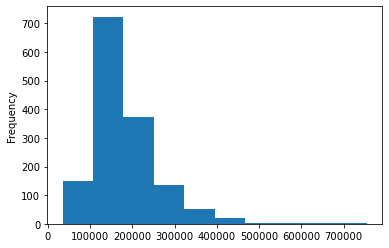

In [6]:
pd.Series(y_train).plot(kind = 'hist',bins=10)

การกระจายตัวค่อนข้างเบ้ไปทางขวา จึงต้องทำการ transform ให้การกระจายเป็นรูปแบบ normal ถึงจะส่งผลดีต่อ Linear model

<AxesSubplot:ylabel='Frequency'>

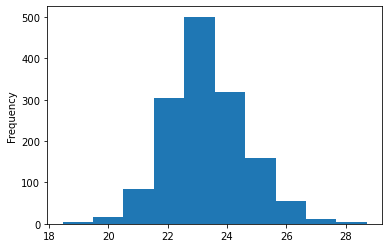

In [7]:
# apply boxcox transform
from scipy.special import boxcox1p
y_train =boxcox1p(y_train,  0.1)
pd.Series(y_train).plot(kind = 'hist',bins=10)

จะเห็นว่าข้อมูลของเรามีการกระจายตัวที่ดีขึ้น

# Impute missing value
* Replace with None
* Replace with Zero
* Replace with Mode

In [8]:
# Look for missing value
na_exist_col = []
for att in df.columns:
    if df.isnull().sum()[att] != 0:
        na_exist_col.append(att)
print(na_exist_col)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


ค่า na ของคอลัมน์เหล่านี้หมายถึง "ไม่มี" ฉะนั้นจะแทนที่ด้วย "None" เนื่องจากเป็นข้อมูลประเภท Categorical

In [9]:
none_replace_list = ['GarageType'
                                 ,'GarageFinish'
                                 ,'GarageQual'
                                 ,'GarageCond'
                                 ,'BsmtQual'
                                 ,'BsmtCond'
                                 ,'BsmtExposure'
                                 ,'BsmtFinType1'
                                 ,'BsmtFinType2'
                                 ,'FireplaceQu'
                                 ,'MasVnrType'
                                 ,'PoolQC'
                                 ,'Alley'
                                 ,'Fence'
                                 ,'MiscFeature'
                                ]
for col in none_replace_list:
    df[col] = df[col].fillna("None")
    if col in na_exist_col:
        na_exist_col.remove(col)

print('Remaining na-existed colL',na_exist_col)

Remaining na-existed colL ['LotFrontage', 'MasVnrArea', 'Electrical', 'GarageYrBlt']


ค่า na ของคอลัมน์เหล่านี้หมายถึงไม่มีและจะแทนที่ด้วย "ศูนย์" เนื่องจากเป็นข้อมูลเชิงปริมาณ

In [10]:
zero_replace_list = ['BsmtFinSF1'
                                 ,'BsmtFinSF2'
                                 ,'BsmtUnfSF'
                                 ,'TotalBsmtSF'
                                 ,'BsmtFullBath'
                                 ,'BsmtHalfBath'
                                 ,'GarageArea'
                                 ,'GarageCars'
                                 ,'MasVnrArea'
                                ]
for col in zero_replace_list:
    if col in df.columns:
        df[col] = df[col].fillna(0)
    if col in na_exist_col:
        na_exist_col.remove(col)

print('Remaining na-existed colL',na_exist_col)

Remaining na-existed colL ['LotFrontage', 'Electrical', 'GarageYrBlt']


ค่า na ของคอลัมน์เหล่านี้จะแทนที่ด้วย Mode

In [11]:
mode_replace_list = ['Electrical'
                                 ,'KitchenQual'
                                 ,'Exterior1st'
                                 ,'Exterior2nd'
                                 ,'SaleType'
                                 ,'MSZoning'
                                 ,'GarageYrBlt'
                                 ,'Utilities'
                                ]
for col in mode_replace_list:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    if col in na_exist_col:
        na_exist_col.remove(col)

print('Remaining na-existed colL',na_exist_col)

Remaining na-existed colL ['LotFrontage']


In [12]:
# เติม functional ที่เป็นค่าว่างว่า typical
df["Functional"] = df["Functional"].fillna("Typ")
if 'Functional' in na_exist_col:
    na_exist_col.remove("Functional")

# LotFrontage หมายถึงพื้นที่ถนนที่จะเข้ามาถึงบ้าน จึงสันนิษฐานได้ว่าค่าของบ้านที่หายไปจะไม่ต่างจากบ้านที่อยู่ใกล้ๆนัก
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

if 'LotFrontage' in na_exist_col:
    na_exist_col.remove("LotFrontage")

In [13]:
# ตรวจสอบอีกครั้งว่ามีค่าที่ว่างอยู่ไหม
df.isnull().sum().sum()

0

In [14]:
df.isna().sum().sum()

0

# Feature Selection

* คัด Quantitative feature ที่ไม่จำเป็นออก

<AxesSubplot:>

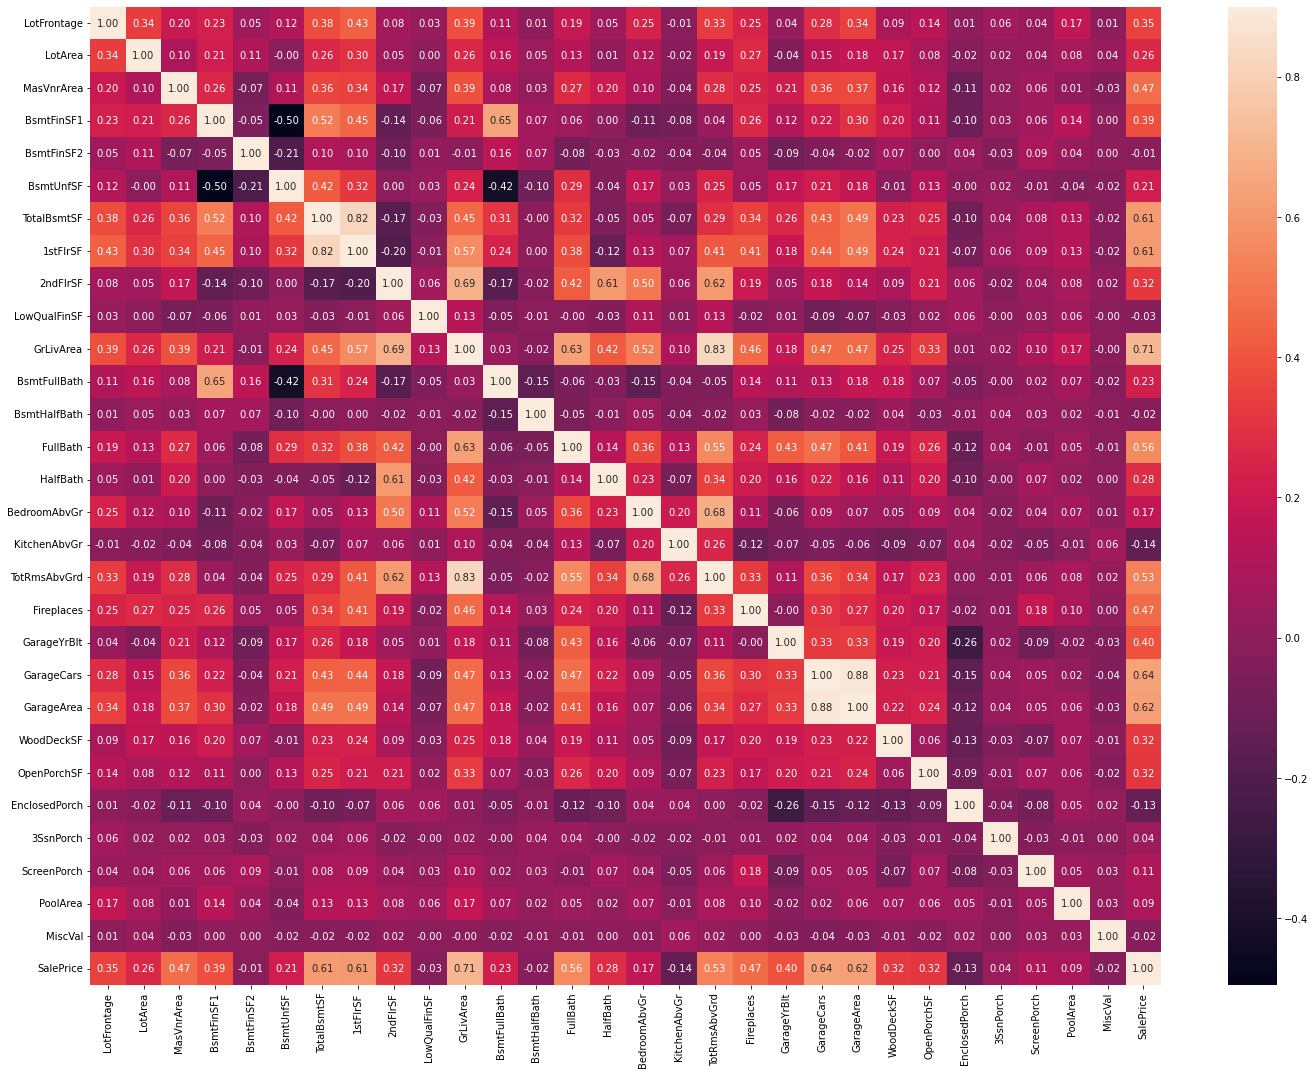

In [15]:
# Correlation map to see how features are correlated with SalePrice
corrmat = df[numerical_feat ].corr()
plt.subplots(figsize=(24,18))
sns.heatmap(corrmat, vmax=0.9, annot=True, fmt=".2f")

Quantitative feature บางตัวมี correlation กับ SalePrice ต่ำ ฉะนั้น feature พวกนี้จึงไม่ช่วยในการทำนายราคาขายเท่าไรนัก

In [16]:
corrmat.SalePrice[abs(corrmat.SalePrice)<0.1]

BsmtFinSF2     -0.011
LowQualFinSF   -0.026
BsmtHalfBath   -0.017
3SsnPorch       0.045
PoolArea        0.092
MiscVal        -0.021
Name: SalePrice, dtype: float64

In [17]:
df.shape

(1460, 80)

In [18]:
# นำ feature เหล่านั้นออก
for feat in corrmat.SalePrice[abs(corrmat.SalePrice)<0.1].index.tolist():
    if feat in df.columns:
        all_data = all_data.drop([feat],axis = 1)
        df = df.drop([feat],axis = 1)
        numerical_feat.remove(feat)

In [19]:
# feature ทั้งหกถูกลบออกไปแล้ว
df.shape

(1460, 74)

# Ordinal Encoding

Predictive model จำเป็นจะต้องเปลี่ยน categorical ให้เป็น numerical ให้หมด ฉะนั้นเราจะแก้ categorical variable ดังนี้

* Ordinal variable - ทำ label encoding
* Nominal variable - ทำ one-hot encoding

In [20]:
# Label Encoding
from sklearn.preprocessing import OrdinalEncoder
ordinal_map = {'Street':['Grvl','Pave']
                        ,'Alley':['None', 'Grvl', 'Pave']
                        ,'LotShape':['Reg', 'IR1', 'IR2', 'IR3']
                        ,'LandSlope':['Gtl', 'Mod', 'Sev']
                        ,'ExterQual':['None','Po','Fa','TA','Gd','Ex']
                        ,'ExterCond':['None','Po','Fa','TA','Gd','Ex']
                        ,'BsmtQual':['None','Po','Fa','TA','Gd','Ex']
                        ,'BsmtCond':['None','Po','Fa','TA','Gd','Ex']
                        ,'BsmtExposure':['None','No','Mn','Av','Gd']
                        ,'BsmtFinType1':['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
                        ,'BsmtFinType2':['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
                        ,'HeatingQC':['None','Po','Fa','TA','Gd','Ex']
                        ,'CentralAir':['N','Y']
                        ,'KitchenQual':['None','Po','Fa','TA','Gd','Ex']
                        ,'FireplaceQu':['None','Po','Fa','TA','Gd','Ex']
                        ,'GarageFinish':['None','Unf','RFn','Fin']
                        ,'GarageQual':['None','Po','Fa','TA','Gd','Ex']
                        ,'GarageCond':['None','Po','Fa','TA','Gd','Ex']
                        ,'PavedDrive':['N','P','Y']
                        ,'PoolQC':['None','Fa','TA','Gd','Ex']
                        ,'Fence':['None', 'MnWw', 'GdWo','MnPrv','GdPrv']
                        ,'Functional':['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
                        ,'OverallCond':[1,2,3,4,5,6,7,8,9,10]
                        ,'OverallQual':[1,2,3,4,5,6,7,8,9,10]
                        ,'YrSold':[2006, 2007, 2008, 2009, 2010]
                        ,'MoSold':[1,2,3,4,5,6,7,8,9,10,11,12]
                        ,'YearBuilt':np.arange(1872,2011).tolist()
                        ,'YearRemodAdd':[1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960
                                                     ,1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971
                                                     ,1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982
                                                     ,1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993
                                                     ,1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004
                                                     ,2005, 2006, 2007, 2008, 2009, 2010]
                       }

for col in ordinal_feat:
    print(col)
    ord_encoder = OrdinalEncoder(categories = [ordinal_map[col]])
    ord_encoder.fit(df[col].to_numpy().reshape(-1, 1))
    df[col] = ord_encoder.transform(df[col].to_numpy().reshape(-1, 1))

Street
Alley
LotShape
LandSlope
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
CentralAir
KitchenQual
FireplaceQu
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
Functional
OverallCond
OverallQual
YrSold
MoSold
YearBuilt
YearRemodAdd


In [21]:
df[ordinal_feat]

,Street,Alley,LotShape,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,PavedDrive,PoolQC,Fence,Functional,OverallCond,OverallQual,YrSold,MoSold,YearBuilt,YearRemodAdd
0,1.000,0.000,0.000,0.000,4.000,3.000,4.000,3.000,1.000,6.000,...,2.000,0.000,0.000,7.000,4.000,6.000,2.000,1.000,131.000,53.000
1,1.000,0.000,0.000,0.000,3.000,3.000,4.000,3.000,4.000,5.000,...,2.000,0.000,0.000,7.000,7.000,5.000,1.000,4.000,104.000,26.000
2,1.000,0.000,1.000,0.000,4.000,3.000,4.000,3.000,2.000,6.000,...,2.000,0.000,0.000,7.000,4.000,6.000,2.000,8.000,129.000,52.000
3,1.000,0.000,1.000,0.000,3.000,3.000,3.000,4.000,1.000,5.000,...,2.000,0.000,0.000,7.000,4.000,6.000,0.000,1.000,43.000,20.000
4,1.000,0.000,1.000,0.000,4.000,3.000,4.000,3.000,3.000,6.000,...,2.000,0.000,0.000,7.000,4.000,7.000,2.000,11.000,128.000,50.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.000,0.000,0.000,0.000,3.000,3.000,4.000,3.000,1.000,1.000,...,2.000,0.000,0.000,7.000,4.000,5.000,1.000,7.000,127.000,50.000
1456,1.000,0.000,0.000,0.000,3.000,3.000,4.000,3.000,1.000,5.000,...,2.000,0.000,3.000,6.000,5.000,5.000,4.000,1.000,106.000,38.000
1457,1.000,0.000,0.000,0.000,5.000,4.000,3.000,4.000,1.000,6.000,...,2.000,0.000,4.000,7.000,8.000,6.000,4.000,4.000,69.000,56.000
1458,1.000,0.000,0.000,0.000,3.000,3.000,3.000,3.000,2.000,6.000,...,2.000,0.000,0.000,7.000,5.000,4.000,4.000,3.000,78.000,46.000


# Label encoding
ปรับค่าของ nominal feature ให้เป็นตัวเลข

In [22]:
df_temp = df.copy()

In [23]:
from sklearn.preprocessing import LabelEncoder
lab_encoder = LabelEncoder()
for col in nominal_feat:
    df_temp[col] = lab_encoder.fit_transform(df_temp[col])

# Visualize data
สร้าง visualization ต่างๆเพื่อประกอบตัดสินใจในขั้นตอนถัดไป

* Categorical data

ทำ feature selection ต่อใน categorical feature โดย plot ดูความสัมพันธ์ระหว่าง SalePrice กับ feature ต่างๆ

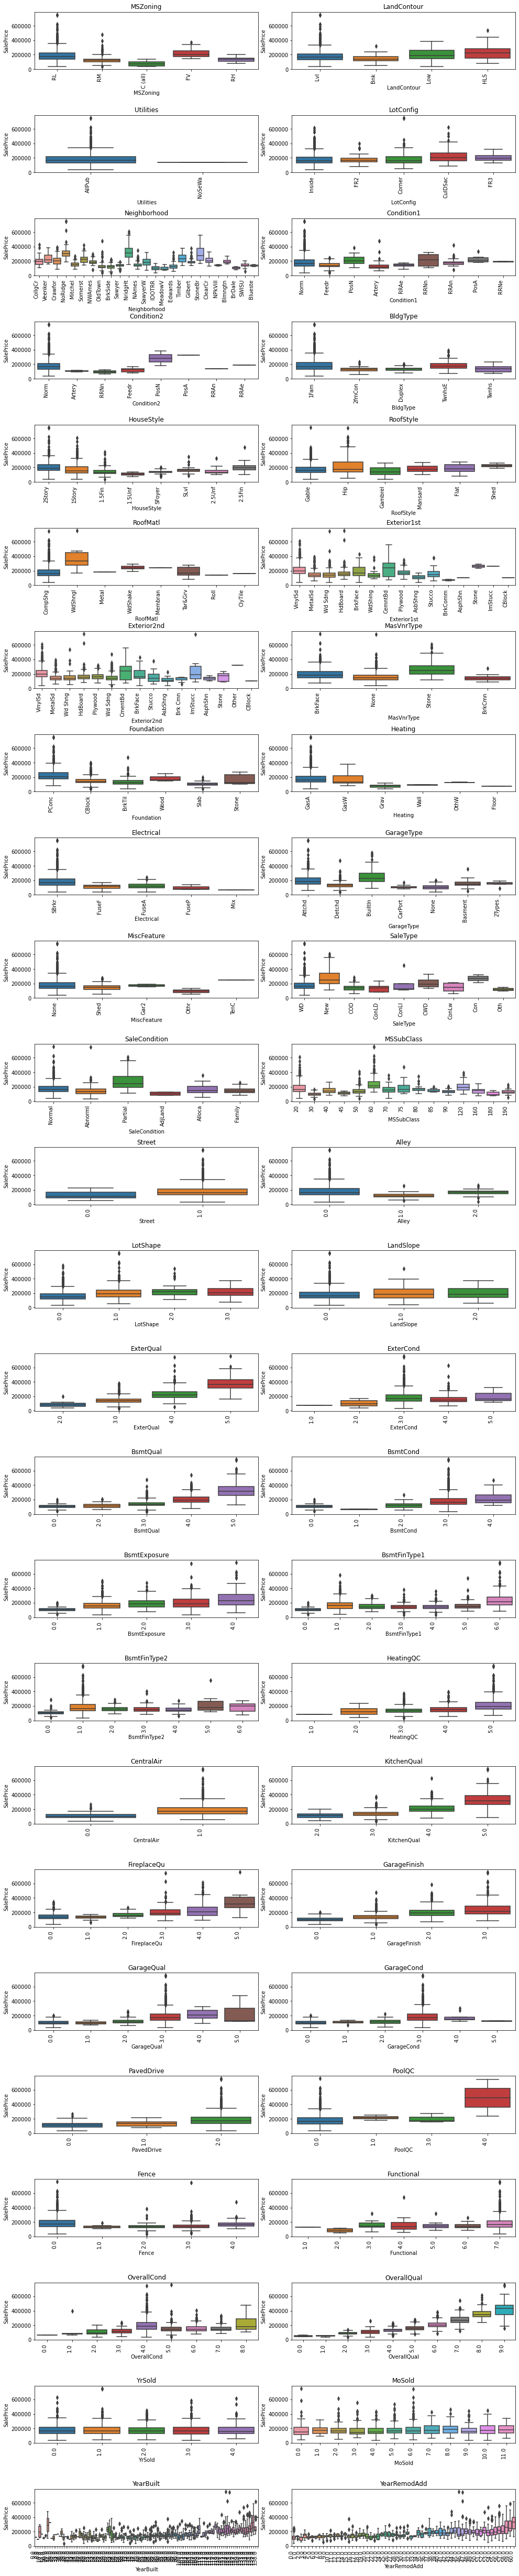

In [24]:
categorical_feat = nominal_feat + ordinal_feat
fig, axes = plt.subplots(nrows=int(len(categorical_feat)/2), ncols=2)
fig.set_size_inches(15, 80)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8
                              ,wspace=0.15)

for i,col in enumerate(categorical_feat):
    bar = sns.boxplot(ax =  axes[i//(2),i%2], data = df, x = col, y = 'SalePrice')    
    axes[i//2,i%2].set_title(col)
    for label in axes[i//2,i%2].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(90)

จะเห็นว่าบาง feature ไม่ได้ช่วยบ่งบอกเลยว่าบ้านจะมีรายได้มากหรือน้อย ฉะนั้นจะนำ feature พวกนี้ออก<br>
ใช้ point biserial test ช่วยคำนวณระดับความสัมพันธ์

In [25]:
# ใช้ point biserial test หาความสัมพันธ์ระหว่าง categorical กับ continuous data
from scipy.stats import pointbiserialr
feature = nominal_feat + ordinal_feat
removed_cat = [col for col in feature if abs(pointbiserialr(df_temp[col], df_temp.SalePrice).correlation) < 0.05]

In [26]:
print('All nominal:\n{}'.format(nominal_feat))
print('All ordinal:\n{}'.format(ordinal_feat))
selected_nominal = list(filter(lambda x: x not in removed_cat,nominal_feat))
selected_ordinal = list(filter(lambda x: x not in removed_cat,ordinal_feat))
print('-'*50)
print('Left nominal:\n{}'.format(selected_nominal))
print('left ordinal:\n{}'.format(selected_ordinal))

All nominal:
['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']
All ordinal:
['Street', 'Alley', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'Functional', 'OverallCond', 'OverallQual', 'YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd']
--------------------------------------------------
Left nominal:
['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', '

* คงเหลือไว้แค่ numerical และ categorical feature ที่เราคัดไว้แล้ว

In [27]:
df = df[numerical_feat + selected_nominal + selected_ordinal]

* Numerical data

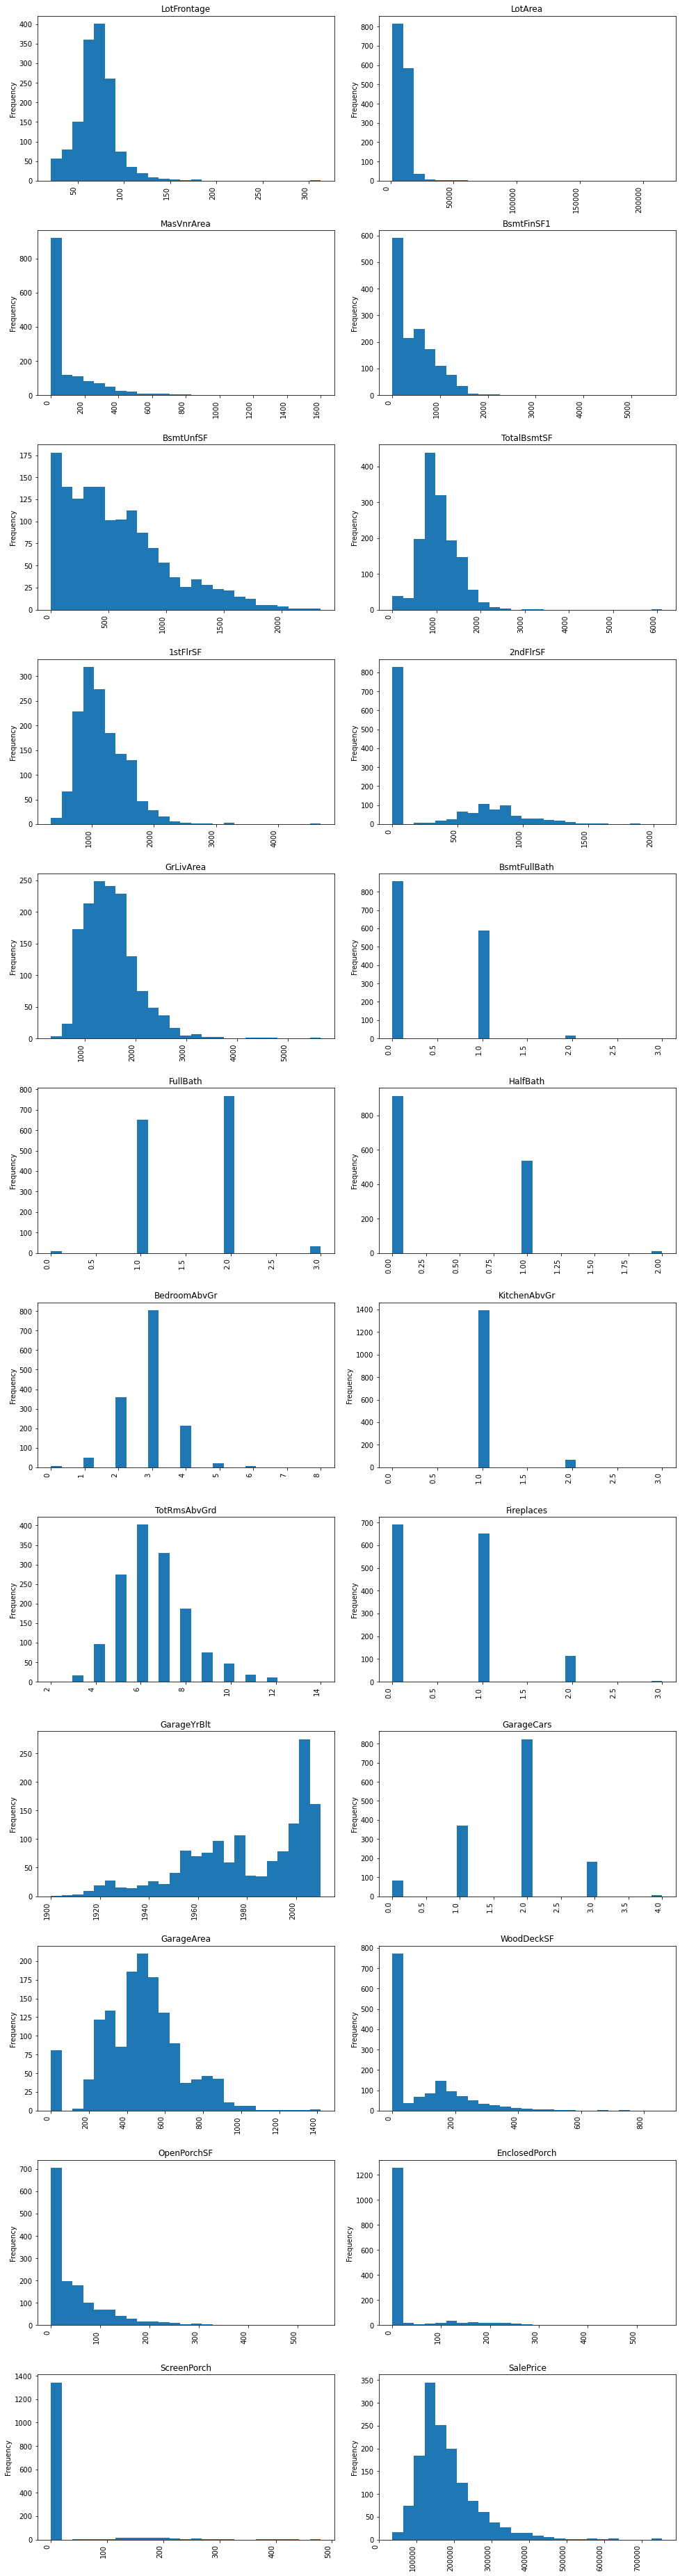

In [28]:
fig, axes = plt.subplots(nrows=int(len(numerical_feat)/2), ncols=2)
fig.set_size_inches(15, 60)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3
                              ,wspace=0.15)

for i,col in enumerate(numerical_feat):
    df[col].plot(kind = 'hist',ax=axes[i//2,i%2],bins=25)
    axes[i//2,i%2].set_title(col)
    for label in axes[i//2,i%2].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(90)

บางคอลัมน์ยังมีการกระจายตัวที่เบ้ และยังมี outlier ฉะนั้นจะทำ boxcox transform 

* Box-Cox transformation กับ numerical column ที่มีค่า skew เกิน 0.75

In [29]:
adjust_skewing_col = df[numerical_feat+selected_ordinal].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
adjust_skewing_col[abs(adjust_skewing_col) > 0.75]

PoolQC          16.834
LotArea         12.195
LandSlope        4.809
KitchenAbvGr     4.484
Alley            4.285
ScreenPorch      4.118
EnclosedPorch    3.087
MasVnrArea       2.675
OpenPorchSF      2.362
LotFrontage      2.211
SalePrice        1.881
Fence            1.805
BsmtFinSF1       1.684
WoodDeckSF       1.540
TotalBsmtSF      1.523
1stFlrSF         1.375
GrLivArea        1.365
LotShape         1.309
BsmtExposure     1.102
BsmtUnfSF        0.919
ExterQual        0.825
2ndFlrSF         0.812
BsmtQual        -1.286
GarageQual      -3.225
PavedDrive      -3.306
GarageCond      -3.328
CentralAir      -3.527
BsmtCond        -3.697
Functional      -4.907
dtype: float64

In [30]:
for feat in adjust_skewing_col.index:
    if feat in df.columns:#df[numerical_feat + selected_ordinal].columns:
        df[feat] = boxcox1p(df[feat], 0.15)

In [31]:
selected_ordinal

['Alley',
 'LotShape',
 'LandSlope',
 'ExterQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'Functional',
 'OverallCond',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd']

In [32]:
df.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice', 'MSZoning',
       'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation',
       'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
       'SaleCondition', 'MSSubClass', 'Alley', 'LotShape', 'LandSlope',
       'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'Functional', 'OverallCond', 'OverallQual', 'YearBuilt',
       'YearRemodAdd'],
      

# One-hot Encoding
เปลี่ยนข้อมูล Nominal ให้เป็น binary feature 0/1

In [33]:
# สร้าง onehot ทิ้งไว้จาก nominal_feat ของ 
df_onehot = pd.get_dummies(df[selected_nominal])

# drop nominal feature ทั้งหมดและเราจะนำ binary feature ที่ได้จาก one-hot encoding มาใส่แทนทีหลัง
df = df.drop(selected_nominal, axis = 1)

In [34]:
df

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,Functional,OverallCond,OverallQual,YearBuilt,YearRemodAdd
0,5.831,19.212,8.059,11.170,7.483,11.693,11.693,11.686,13.699,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,7.201,5.461
1,6.221,19.712,0.000,12.063,8.898,12.792,12.792,0.000,12.792,0.000,...,1.541,1.541,1.194,0.000,0.000,2.440,2.440,2.056,6.733,4.263
2,5.915,20.347,7.647,10.200,9.917,11.892,11.892,11.725,13.832,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,7.169,5.427
3,5.685,19.692,0.000,8.274,10.468,11.354,12.014,11.354,13.711,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,5.094,3.859
4,6.315,21.325,9.392,10.971,10.221,12.511,12.511,12.271,14.480,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.440,7.153,5.357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,5.744,18.961,0.000,0.000,11.990,11.990,11.990,11.125,13.585,0.000,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.056,7.137,5.357
1456,6.338,20.995,7.004,11.473,10.693,13.386,14.295,0.000,14.295,0.730,...,1.541,1.541,1.194,0.000,1.541,2.260,2.056,2.056,6.771,4.883
1457,5.860,19.476,0.000,8.823,11.759,12.528,12.617,12.528,14.679,0.000,...,1.541,1.541,1.194,0.000,1.820,2.440,2.603,2.260,5.942,5.559
1458,5.915,19.760,0.000,5.322,0.000,12.338,12.338,0.000,12.338,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,2.056,1.820,6.173,5.211


In [35]:
df = pd.concat([df,df_onehot],axis = 1)
df = df.drop('SalePrice',axis = 1)
numerical_feat.remove('SalePrice')
column = df.columns
df

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831,19.212,8.059,11.170,7.483,11.693,11.693,11.686,13.699,0.730,...,0,0,0,1,0,0,0,0,1,0
1,6.221,19.712,0.000,12.063,8.898,12.792,12.792,0.000,12.792,0.000,...,0,0,0,1,0,0,0,0,1,0
2,5.915,20.347,7.647,10.200,9.917,11.892,11.892,11.725,13.832,0.730,...,0,0,0,1,0,0,0,0,1,0
3,5.685,19.692,0.000,8.274,10.468,11.354,12.014,11.354,13.711,0.730,...,0,0,0,1,1,0,0,0,0,0
4,6.315,21.325,9.392,10.971,10.221,12.511,12.511,12.271,14.480,0.730,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,5.744,18.961,0.000,0.000,11.990,11.990,11.990,11.125,13.585,0.000,...,0,0,0,1,0,0,0,0,1,0
1456,6.338,20.995,7.004,11.473,10.693,13.386,14.295,0.000,14.295,0.730,...,0,0,0,1,0,0,0,0,1,0
1457,5.860,19.476,0.000,8.823,11.759,12.528,12.617,12.528,14.679,0.000,...,0,0,0,1,0,0,0,0,1,0
1458,5.915,19.760,0.000,5.322,0.000,12.338,12.338,0.000,12.338,0.730,...,0,0,0,1,0,0,0,0,1,0


* Scale data

เมื่อทุก column ถูกแปลงให้เป็นประเภท numerical แล้ว เราจะต้องสเกลค่าในแต่ละคอลัมน์เพื่อไม่ให้คอลัมน์ที่มีขนาดใหญ่ครอบงำการแปรผลของโมเดลมาเกินไป ในที่นี้เราจะทำ RobustScaling โดยใส่กระบวนการลงใน Pipeline ของทุกโมเดลเพื่อปรับสเกลข้อมูล โดย Robust จะหลีกเลี่ยงผลจาก outlier ในการแปลงค่า<br>
เราจะสเกลทุกๆ feature ให้มีขนาดไม่เกิน1 ยกเว้น binary feature ที่มีค่า 0 และ 1 อยู่แล้ว

In [36]:
from sklearn import preprocessing
# นำ SalePrice ออก
#df.drop('SalePrice', axis = 1)

scaler = preprocessing.RobustScaler()
df[numerical_feat + selected_ordinal] = scaler.fit_transform(df[numerical_feat + selected_ordinal])
#df = scaler.fit_transform(df)

In [37]:
# Save
xtrain = pd.DataFrame(data = df , columns = column)

# Test some models

In [38]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand
import xgboost as xgb
import lightgbm as lgb

* function สำหรับ cross validate 

In [39]:
def evaluate_performance(model,X_train,y_train):   
    k_folds = KFold(n_splits = 5)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = k_folds))
    print('Cross-Val R2:',cross_val_score(model, X_train, y_train, scoring="r2", cv = k_folds))
    print('Average Y valid: ',y_train.mean())    
    print('Negative MSE:',scores)

* Lasso

In [40]:
X_train = df
model_lasso = Lasso(random_state=42)

In [41]:
# ใช้ GridSearchCV ช่วยเลือก HyperParemeter
from sklearn.model_selection import GridSearchCV
lasso_grid = {'alpha':[0.0006, 0.06, 0.5, 0.0001, 0.01, 2, 3, 4, 5, 10, 50, 100,1000]} 
grid = GridSearchCV(estimator=model_lasso, param_grid=lasso_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv = 5)
grid.fit(X_train, y_train)
model_lasso = model_lasso.set_params(**grid.best_params_)

In [42]:
model_lasso

Lasso(alpha=0.0006, random_state=42)

* Ridge

In [43]:
model_ridge = Ridge(random_state=42)
grid = GridSearchCV(estimator=model_ridge, param_grid=lasso_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv = 5)
grid.fit(X_train, y_train)
model_ridge = model_ridge.set_params(**grid.best_params_)

* Elastic Net

In [44]:
elastic_param_grid = {'alpha':[0.0006, 0.06, 0.5, 0.0001, 0.01, 2, 3, 4, 5, 10, 50, 100,1000],
                                    'l1_ratio': [0.05, 0.1, 0.25, 0.5, 0.75]}
model_enet = ElasticNet(random_state=42)
grid = GridSearchCV(estimator=model_enet, param_grid=elastic_param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv = 5)
grid.fit(X_train, y_train)
model_enet = model_enet.set_params(**grid.best_params_)

ลองโมเดล ensemble-base ดูบ้าง
* GBOOST

In [45]:
boost_grid = {'n_estimators': [25,100, 500, 1000, 5000],  
                        'max_depth': [3, 4, 5, 6],
                        'learning_rate' :[0.01, 0.05, 0.1]
                         }

model_gboost = GradientBoostingRegressor(loss='huber', max_features='sqrt',
                                                                       min_samples_leaf=5, min_samples_split=10,
                                                                       random_state=42)

grid = GridSearchCV(estimator=model_gboost, param_grid=boost_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv = 5)
grid.fit(X_train, y_train)
model_gboost = model_gboost.set_params(**grid.best_params_)

In [46]:
evaluate_performance(model_lasso,X_train,y_train)
print('-'*150)
evaluate_performance(model_ridge,X_train,y_train)
print('-'*150)
evaluate_performance(model_gboost,X_train,y_train)

Cross-Val R2: [0.93342373 0.89450806 0.90962075 0.91337382 0.85069084]
Average Y valid:  23.3077284308275
Negative MSE: [0.33325056 0.45975188 0.41378448 0.37153561 0.50715481]
------------------------------------------------------------------------------------------------------------------------------------------------------
Cross-Val R2: [0.92436812 0.89267405 0.9052684  0.91193341 0.84671892]
Average Y valid:  23.3077284308275
Negative MSE: [0.35519235 0.46373112 0.42363055 0.3746118  0.51385619]
------------------------------------------------------------------------------------------------------------------------------------------------------
Cross-Val R2: [0.93026431 0.89981428 0.91552842 0.92781075 0.89079407]
Average Y valid:  23.3077284308275
Negative MSE: [0.34106621 0.44803999 0.40003238 0.33916586 0.43373097]


In [47]:
from sklearn.model_selection import cross_val_predict
from scipy.special import boxcox1p, inv_boxcox
y_train_true = inv_boxcox(y_train, 0.1)
y_train_pred1 = inv_boxcox(cross_val_predict(model_lasso,X_train,y_train,cv=KFold(n_splits = 5)), 0.1)
y_train_pred2 = inv_boxcox(cross_val_predict(model_gboost,X_train,y_train,cv=KFold(n_splits = 5)), 0.1)

* แสดงผลการ cross validation คร่าวๆ จะสังเกตได้ว่าโมเดลทำนายส่วนที่ราคาสูงๆไม่ค่อยถูก

Text(0, 0.5, 'Price')

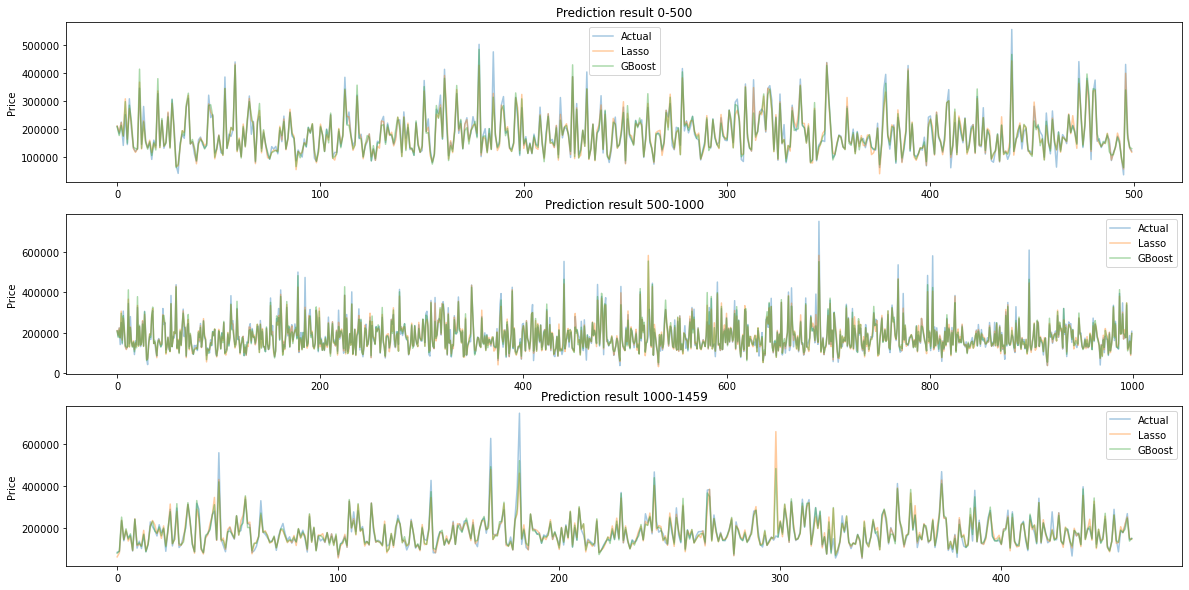

In [48]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(20,10)
ax[0].plot(y_train_true[:500],alpha = 0.4, label = 'Actual')
ax[0].plot(y_train_pred1[:500],alpha = 0.4, label = 'Lasso')
ax[0].plot(y_train_pred2[:500],alpha = 0.4, label = 'GBoost')
ax[0].legend()
ax[0].set_title('Prediction result 0-500')
ax[0].set_ylabel("Price")

ax[1].plot(y_train_true[:1000],alpha = 0.4, label = 'Actual')
ax[1].plot(y_train_pred1[:1000],alpha = 0.4, label = 'Lasso')
ax[1].plot(y_train_pred2[:1000],alpha = 0.4, label = 'GBoost')
ax[1].legend()
ax[1].set_title('Prediction result 500-1000')
ax[1].set_ylabel("Price")

ax[2].plot(y_train_true[1000:],alpha = 0.4, label = 'Actual')
ax[2].plot(y_train_pred1[1000:],alpha = 0.4, label = 'Lasso')
ax[2].plot(y_train_pred2[1000:],alpha = 0.4, label = 'GBoost')
ax[2].legend()
ax[2].set_title('Prediction result 1000-1459')
ax[2].set_ylabel("Price")

# เพิ่มการทำนายเป็นสองชั้น
ref: https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
* เริ่มจากใช้แบ่ง train set เป็นจำนวน n folds ก่อน จากนั้นใช้ base model (จำนวน k model) มาทำนาย train set ที่แบ่ง
* จากนั้นนำผลลัพธ์ k ชุดมาต่อกัน และนำไปให้ train meta model อีกครั้ง
* นำ test set มาทำนายด้วย base model ทั้งหมด k โมเดล โมเดลละ n ครั้งแล้วเฉลี่ยกัน จากนั้นนำผลเฉลี่ยจาก base model ให้ meta model ทำนาย

In [49]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds   
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # สร้างโมเดลย่อยของแต่ละ base model ตามจำนวน fold ที่กำหนด
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                # โมเดลแต่ละตัว fit กับ train data คนละ Fold กัน เราจึงเก็บ model ที่ fit กับแต่ละ Fold ไว้ใน list 
                # และหลังจากนี้เราจะนำค่าเฉลี่ยของทุก fit มาเฉลี่ยกัน
                # สมมติว่าใช้ n_folds = 5 ก็จะมีโมเดลแบบเดียวกันทั้งหมด 5 fits
                self.base_models_[i].append(instance) #เก็บโมเดลของ fit นี้ไว้ก่อน
                instance.fit(X[train_index], y[train_index]) # fit โมเดลนี้กับ folds ส่วนที่เป็น train
                y_pred = instance.predict(X[holdout_index]) # ใช้ model ที่เพิ่ง fit ไปกับ fold ส่วนที่เป็น test
                out_of_fold_predictions[holdout_index, i] = y_pred # เซฟคำตอบของ test ไว้ในคอลัมน์ i ของ array 2 มิติที่เราสร้างไว้
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

* ใช้ Elastic Net, Ridge, และ GBoost เป็น Base model 
* ใช้ Lasso เป็น Meta model

In [50]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_enet, model_ridge, model_gboost)
                                                 ,meta_model = model_lasso)

In [51]:
stacked_averaged_models.fit(X_train.to_numpy(),y_train)

StackingAveragedModels(base_models=(ElasticNet(alpha=0.0006, l1_ratio=0.75,
                                               random_state=42),
                                    Ridge(alpha=10, random_state=42),
                                    GradientBoostingRegressor(learning_rate=0.01,
                                                              loss='huber',
                                                              max_depth=4,
                                                              max_features='sqrt',
                                                              min_samples_leaf=5,
                                                              min_samples_split=10,
                                                              n_estimators=5000,
                                                              random_state=42)),
                       meta_model=Lasso(alpha=0.0006, random_state=42))

In [52]:
evaluate_performance(stacked_averaged_models,X_train.to_numpy(),y_train)

Cross-Val R2: [0.93551641 0.904986   0.91896759 0.93028398 0.87764869]
Average Y valid:  23.3077284308275
Negative MSE: [0.32797123 0.43632258 0.39180432 0.33330524 0.45909402]


In [53]:
y_train_pred3 = inv_boxcox(cross_val_predict(stacked_averaged_models,X_train.to_numpy(),y_train,cv=KFold(n_splits = 5)), 0.1)

# Apply pipeline to test data

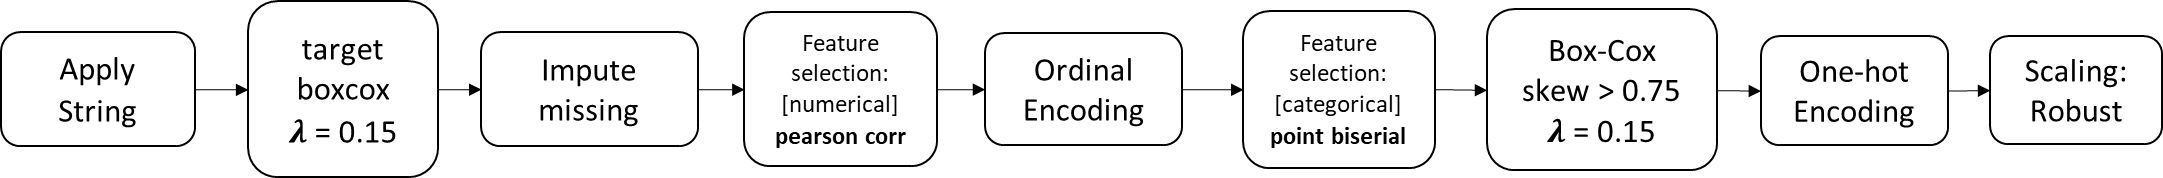

In [54]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# all_data ใช้สำหรับตอนทำ test data เท่านั้น ไม่งั้นจะเกิด data leakage
all_data = pd.concat((df, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)


In [55]:
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.000,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.000,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.000,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.000,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [56]:
# column
print('Numerical feature: ',numerical_feat)
print('-'*150)
print('Ordinal feature: ',selected_ordinal)
print('-'*150)
print('Numerical feature: ',selected_nominal)  

Numerical feature:  ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']
------------------------------------------------------------------------------------------------------------------------------------------------------
Ordinal feature:  ['Alley', 'LotShape', 'LandSlope', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'Functional', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd']
------------------------------------------------------------------------------------------------------------------------------------------------------
Numerical feature:  ['M

* Impute missing value

เราจะใช้ train data ช่วยในการเติม missing value ของเทสด้วย

In [57]:
# Look for missing value
na_exist_col = []
for att in all_data.columns:
    if all_data.isnull().sum()[att] != 0:
        na_exist_col.append(att)
print(na_exist_col)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [58]:
none_replace_list = ['GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure'
                                 ,'BsmtFinType1','BsmtFinType2','FireplaceQu','MasVnrType','PoolQC','Alley' ,'Fence','MiscFeature']
zero_replace_list = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageArea'
                                 ,'GarageCars','MasVnrArea']
mode_replace_list = ['Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType','MSZoning','GarageYrBlt','Utilities']

for col in none_replace_list:
    all_data[col] = all_data[col].fillna("None")
    if col in na_exist_col:
        na_exist_col.remove(col)
        
for col in zero_replace_list:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)
    if col in na_exist_col:
        na_exist_col.remove(col)

for col in mode_replace_list:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    if col in na_exist_col:
        na_exist_col.remove(col)

# เติม functional ที่เป็นค่าว่างว่า typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")
if 'Functional' in na_exist_col:
    na_exist_col.remove("Functional")

# LotFrontage หมายถึงพื้นที่ถนนที่จะเข้ามาถึงบ้าน จึงสันนิษฐานได้ว่าค่าของบ้านที่หายไปจะไม่ต่างจากบ้านที่อยู่ใกล้ๆนัก
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
if 'LotFrontage' in na_exist_col:
    na_exist_col.remove("LotFrontage")
    
# ตรวจสอบอีกครั้งว่ามีค่าที่ว่างอยู่ไหม
print(all_data.isnull().sum().sum())
print(all_data.isna().sum().sum())

0
0


In [59]:
#numerical_feat.remove('SalePrice')
all_data = all_data[numerical_feat + selected_nominal + selected_ordinal]

* Ordinal encoding

In [60]:
for col in selected_ordinal:
    print(col)
    ord_encoder = OrdinalEncoder(categories = [ordinal_map[col]])
    ord_encoder.fit(all_data[col].to_numpy().reshape(-1, 1))
    all_data[col] = ord_encoder.transform(all_data[col].to_numpy().reshape(-1, 1))

Alley
LotShape
LandSlope
ExterQual
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
HeatingQC
CentralAir
KitchenQual
FireplaceQu
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
Functional
OverallCond
OverallQual
YearBuilt
YearRemodAdd


* Box-cox

In [61]:
adjust_skewing_col = all_data[numerical_feat+selected_ordinal].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
adjust_skewing_col[abs(adjust_skewing_col) > 0.75]
for feat in adjust_skewing_col.index:
    if feat in df.columns:#df[numerical_feat + selected_ordinal].columns:
        all_data[feat] = boxcox1p(all_data[feat], 0.15)

In [62]:
all_data

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,Functional,OverallCond,OverallQual,YearBuilt,YearRemodAdd
0,5.831,19.212,8.059,11.170,7.483,11.693,11.693,11.686,13.699,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,7.201,5.461
1,6.221,19.712,0.000,12.063,8.898,12.792,12.792,0.000,12.792,0.000,...,1.541,1.541,1.194,0.000,0.000,2.440,2.440,2.056,6.733,4.263
2,5.915,20.347,7.647,10.200,9.917,11.892,11.892,11.725,13.832,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,7.169,5.427
3,5.685,19.692,0.000,8.274,10.468,11.354,12.014,11.354,13.711,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,5.094,3.859
4,6.315,21.325,9.392,10.971,10.221,12.511,12.511,12.271,14.480,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.440,7.153,5.357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.933,14.081,0.000,0.000,10.497,10.497,10.497,10.497,12.375,0.000,...,0.000,0.000,1.194,0.000,0.000,2.440,2.260,1.541,6.615,3.859
2915,3.933,14.013,0.000,8.622,8.979,10.497,10.497,10.497,12.375,0.000,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,1.541,6.615,3.859
2916,7.620,22.782,0.000,12.703,0.000,12.703,12.703,0.000,12.703,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,2.260,1.820,6.405,5.211
2917,5.744,20.047,0.000,9.301,10.630,11.868,12.040,0.000,12.040,0.000,...,0.000,0.000,1.194,0.000,1.541,2.440,1.820,1.820,7.021,5.053


* One-hot

In [63]:
# สร้าง onehot ทิ้งไว้จาก nominal_feat ของ 
df_onehot = pd.get_dummies(all_data[selected_nominal])

# drop nominal feature ทั้งหมดและเราจะนำ binary feature ที่ได้จาก one-hot encoding มาใส่แทนทีหลัง
all_data = all_data.drop(selected_nominal, axis = 1)
all_data

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,Functional,OverallCond,OverallQual,YearBuilt,YearRemodAdd
0,5.831,19.212,8.059,11.170,7.483,11.693,11.693,11.686,13.699,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,7.201,5.461
1,6.221,19.712,0.000,12.063,8.898,12.792,12.792,0.000,12.792,0.000,...,1.541,1.541,1.194,0.000,0.000,2.440,2.440,2.056,6.733,4.263
2,5.915,20.347,7.647,10.200,9.917,11.892,11.892,11.725,13.832,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,7.169,5.427
3,5.685,19.692,0.000,8.274,10.468,11.354,12.014,11.354,13.711,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.260,5.094,3.859
4,6.315,21.325,9.392,10.971,10.221,12.511,12.511,12.271,14.480,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,2.440,7.153,5.357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.933,14.081,0.000,0.000,10.497,10.497,10.497,10.497,12.375,0.000,...,0.000,0.000,1.194,0.000,0.000,2.440,2.260,1.541,6.615,3.859
2915,3.933,14.013,0.000,8.622,8.979,10.497,10.497,10.497,12.375,0.000,...,1.541,1.541,1.194,0.000,0.000,2.440,1.820,1.541,6.615,3.859
2916,7.620,22.782,0.000,12.703,0.000,12.703,12.703,0.000,12.703,0.730,...,1.541,1.541,1.194,0.000,0.000,2.440,2.260,1.820,6.405,5.211
2917,5.744,20.047,0.000,9.301,10.630,11.868,12.040,0.000,12.040,0.000,...,0.000,0.000,1.194,0.000,1.541,2.440,1.820,1.820,7.021,5.053


In [64]:
all_data = pd.concat([all_data,df_onehot],axis = 1)
column = all_data.columns
all_data

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831,19.212,8.059,11.170,7.483,11.693,11.693,11.686,13.699,0.730,...,0,0,0,1,0,0,0,0,1,0
1,6.221,19.712,0.000,12.063,8.898,12.792,12.792,0.000,12.792,0.000,...,0,0,0,1,0,0,0,0,1,0
2,5.915,20.347,7.647,10.200,9.917,11.892,11.892,11.725,13.832,0.730,...,0,0,0,1,0,0,0,0,1,0
3,5.685,19.692,0.000,8.274,10.468,11.354,12.014,11.354,13.711,0.730,...,0,0,0,1,1,0,0,0,0,0
4,6.315,21.325,9.392,10.971,10.221,12.511,12.511,12.271,14.480,0.730,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.933,14.081,0.000,0.000,10.497,10.497,10.497,10.497,12.375,0.000,...,0,0,0,1,0,0,0,0,1,0
2915,3.933,14.013,0.000,8.622,8.979,10.497,10.497,10.497,12.375,0.000,...,0,0,0,1,1,0,0,0,0,0
2916,7.620,22.782,0.000,12.703,0.000,12.703,12.703,0.000,12.703,0.730,...,0,0,0,1,1,0,0,0,0,0
2917,5.744,20.047,0.000,9.301,10.630,11.868,12.040,0.000,12.040,0.000,...,0,0,0,1,0,0,0,0,1,0


In [65]:
scaler = preprocessing.RobustScaler()
all_data = scaler.fit_transform(all_data)

In [66]:
all_data

array([[-0.25647644, -0.255417  ,  1.05125291, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46996417,  0.0354761 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.10068914,  0.40491476,  0.99743391, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.07630747,  1.82139435,  0.        , ...,  0.        ,
        -1.        ,  0.        ],
       [-0.41840365,  0.22998865,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19434966,  0.04194187,  0.85219829, ...,  0.        ,
         0.        ,  0.        ]])

In [67]:
all_data = pd.DataFrame(data = all_data , columns = column)

In [68]:
x_test = all_data[1460:]

In [69]:
x_test

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,0.470,0.482,0.000,0.053,-0.411,-0.228,-0.403,0.000,-1.058,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1461,0.514,0.975,0.888,0.212,-0.108,0.607,0.453,0.000,-0.189,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1462,0.194,0.899,0.000,0.174,-0.875,-0.127,-0.329,0.999,0.279,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1463,0.380,0.125,0.503,0.110,-0.278,-0.132,-0.334,0.991,0.243,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1464,-1.631,-1.393,0.000,-0.070,0.646,0.528,0.369,0.000,-0.274,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.794,-3.240,0.000,-0.844,0.124,-1.141,-1.409,0.940,-0.629,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2915,-3.794,-3.280,0.000,-0.079,-0.349,-1.141,-1.409,0.940,-0.629,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-1.000,0.000
2916,3.076,1.821,0.000,0.283,-3.147,0.435,0.270,0.000,-0.375,1.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-1.000,0.000
2917,-0.418,0.230,0.000,-0.019,0.165,-0.162,-0.235,0.000,-0.887,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [70]:
stacked_averaged_models.fit(xtrain.to_numpy(),y_train)
result = stacked_averaged_models.predict(x_test.to_numpy())

In [71]:
result

array([22.19221519, 23.05538721, 23.61373071, ..., 23.23530456,
       22.08560805, 24.22528713])

* revert box-cox กลับมา

In [72]:
inv_boxcox(result, 0.1)

array([119538.72559876, 155748.00376408, 184148.06739735, ...,
       164435.89585141, 115638.5771698 , 220531.68872866])

In [73]:
inv_boxcox(result, 0.1).shape

(1459,)

In [74]:
pd.DataFrame(data = inv_boxcox(result, 0.1)).to_csv('predict.csv')

จากนั้นลองเอาไปส่งดู....

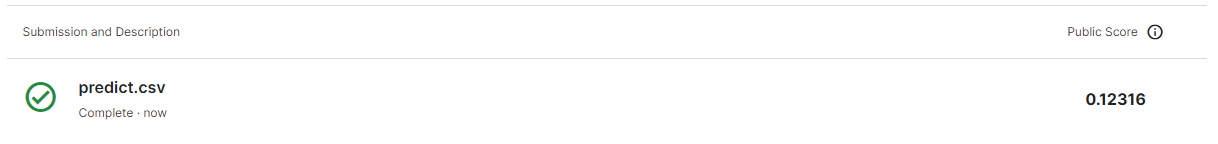

คะแนนดีใช้ได้เลย ^^

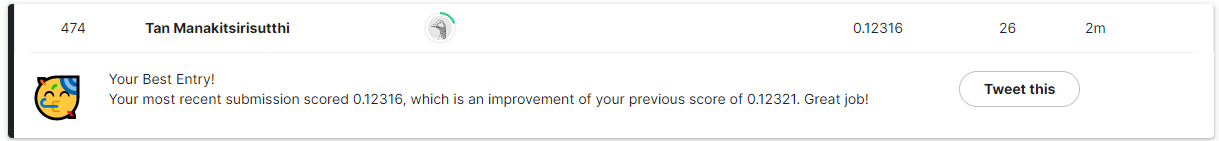

อันดับ ณ.ตอนส่งจะอยู่ที่ราวๆ 400เกือบๆ500

# แนวทางการเพิ่มความแม่นยำที่ทำได้
อันที่จริงแล้วยังมีอีกหลายอย่างที่น่าจะยังเพิ่มคะแนนได้ เช่น
* <b>การทำ Feature engineering</b> เพิ่มเติม โดยเพิ่มคอลัมน์ที่ช่วยโมเดลทำนาย เช่น เราอาจจะเพิ่มคอลัมน์ 1stFlrSF + 2ndFlrSF - LowQualFinSF ซึ่งบ่งบอกถึงพื้นที่ใช้สอยได้ในบ้าน เนื่องจาก feature พวกนี้ค่อนข้างมีความสำคัญ (สังเกตจาก correlation และ visualization) 
* Categorical บาง feature ยังมีความกำกวม เช่น Electrical
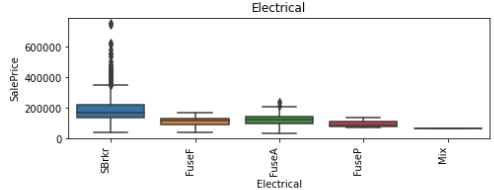

ค่าต่างๆมีความหมายคือ
* SBrkr -	Standard Circuit Breakers & Romex
* FuseA -	Fuse Box over 60 AMP and all Romex wiring (Average)	
* FuseF -	60 AMP Fuse Box and mostly Romex wiring (Fair)
* FuseP -	60 AMP Fuse Box and mostly knob & tube wiring (poor)
* Mix - Mixed

จะเห็นว่าระดับของข้อมูลจะดูเหมือนเป็น nominal (แยกเป็นระบบป้องกันไฟด้วยเบรคเกอร์ ฟิวส์ หรือใช้ทั้งคู่) แต่จริงๆแล้วฟิวส์กลับมีระดับที่ทั้งดี ปานกลาง และแย่ (กระนั้น FuseA FuseF FuseP ก็ไม่ค่อยมีผลอะไรกับราคา)<br>
ฉะนั้นเราอาจจะยุบพวกที่เป็นฟิวส์ให้มีค่าเดียวกันเลย และ feature นี้จะมีระดับความละเอียดเป็น nominal

* <b>เพิ่ม Layer การทำนายขึ้นอีก</b> ใช้ผลลัพธ์จากการทำนายของโมเดลรอบแรกมาเป็น feature ให้กับโมเดลระดับต่อไป
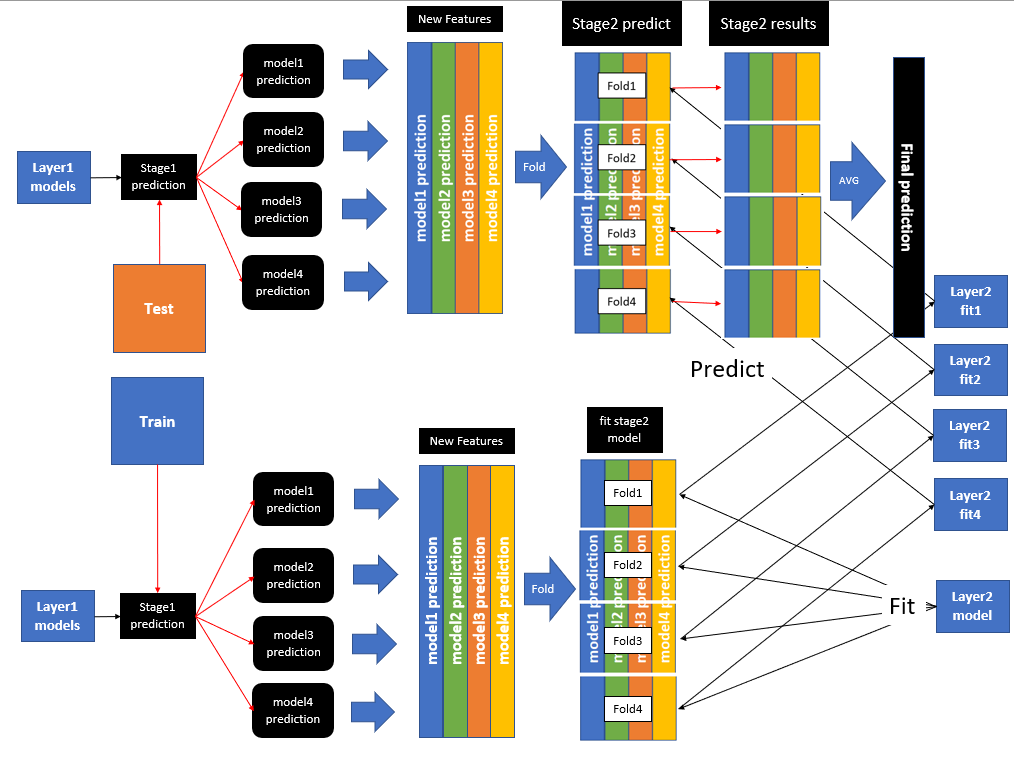

---------------------------------------------------------------------------------------------THE END---------------------------------------------------------------------------------------------